In [1]:
import numpy as np
import glob, os, re, sys
from pathlib import Path
sys.path.append('../')

import pandas as pd
import polars as pl
from scipy.stats import binned_statistic

import astro_helper as ah
import configparser
config = configparser.ConfigParser()
config.read('../config_allgas.ini')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from matplotlib import rc
rc('axes', linewidth=1.5)
rc('axes', edgecolor='#3C3C3C')
plt.style.use('mpl_style_Jeffreson.mplstyle')
custom_colors = {
    'grey': '#3C3C3C',
    'turquoise': '#5E9F87'
}

In [2]:
tags = ['ETG-vlM', 'ETG-lowM', 'ETG-medM', 'ETG-hiM', 'MW']
tagdirs = [Path(config[tag]['SAVE_DIR']) / Path(config[tag]['SUBDIR']) for tag in tags]
xymaxs = [config[tag].getfloat('XYMAX') for tag in tags] # kpc
xybinwidths = [config[tag].getfloat('XYBINWIDTH') for tag in tags] # pc
xybinnos = [int(np.rint(2.*xymax * ah.kpc_to_cm / (xybinwidth * ah.pc_to_cm))) for xymax, xybinwidth in zip(xymaxs, xybinwidths)]

# real weight

In [3]:
df = pl.read_parquet('/n/holystore01/LABS/itc_lab/Users/sjeffreson/GalactISM/GalactISM.parquet').to_pandas()

In [4]:
# separate by galaxy
SigmaSFRs_gal, Rs_gal = [], []
for tag, xymax in zip(tags, xymaxs):
    mask = df['galaxy'] == tag
    SigmaSFRs_gal.append(df.loc[mask, 'SFR_surfdens'])
    Rs_gal.append(df.loc[mask, 'R/Router'] * xymax)

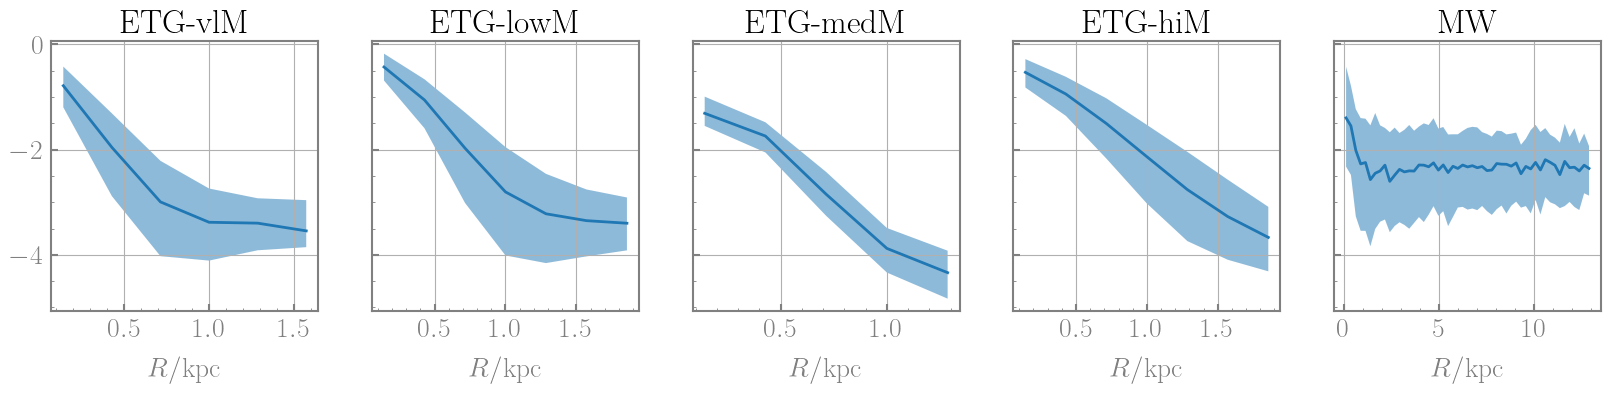

In [5]:
np.seterr(divide='ignore', invalid='ignore')
fig, axs = plt.subplots(1, len(tags), figsize=(4*len(tags), 3.5), sharey=True)
for ax, tag, SigmaSFRs, Rs, xymax in zip(axs, tags, SigmaSFRs_gal, Rs_gal, xymaxs):
    bins = np.linspace(0., xymax, int(np.rint(xymax/0.25)))
    Rbins = 0.5*(bins[:-1] + bins[1:])
    cnd = SigmaSFRs > 0.
    SFRs_med, _, _ = binned_statistic(Rs[cnd], SigmaSFRs[cnd], bins=bins, statistic='median')
    SFRs_q1, _, _ = binned_statistic(Rs[cnd], SigmaSFRs[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    SFRs_q4, _, _ = binned_statistic(Rs[cnd], SigmaSFRs[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    ax.plot(Rbins, np.log10(SFRs_med/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s), lw=2)
    ax.fill_between(Rbins,
                    np.log10(SFRs_q1/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s),
                    np.log10(SFRs_q4/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s), alpha=0.5)
    ax.set_xlabel(r'$R/{\rm kpc}$')
    ax.set_title(tag)
    ax.tick_params(axis='both', direction='in', which='both')
    ax.minorticks_on()
    ax.grid(True)
plt.show()

# PRFM star formation

In [6]:
SigmaSFRs_gal_PRFM, Rs_gal_PRFM = [], []
for tag, xymax in zip(tags, xymaxs):
    mask = df['galaxy'] == tag
    SigmaGas = df.loc[mask, 'gas_surfdens']
    SigmaStars = df.loc[mask, 'star_surfdens']
    vcs = df.loc[mask, 'rotcurve']
    Rs = df.loc[mask, 'R/Router'] * xymax
    rhodms = df.loc[mask, 'dm_voldens']
    Omegas2 = 4. * np.pi * ah.G_cgs * rhodms
    sigmaEffs = 12.e5*np.ones(len(Rs)) # cm/s

    i = 0
    while i < 10:
        i += 1
        weights_geom = SigmaGas / 4. * (
            np.pi * ah.G_cgs * (SigmaGas + SigmaStars) +
            np.sqrt((np.pi * ah.G_cgs * (SigmaGas + SigmaStars))**2 + 8./3. * Omegas2**2 * sigmaEffs**2)
        )/ah.kB_cgs
        sigmaEffs = 12.e5 * (weights_geom/1.e4)**0.22
    
    Upsilon = pow(10, -0.212 * np.log10(weights_geom) + 3.86) * ah.kms_to_cms

    tau_dyn = SigmaGas * sigmaEffs / (weights_geom*ah.kB_cgs)
    tau_dep = Upsilon * tau_dyn / sigmaEffs

    SigmaSFR = SigmaGas / tau_dep

    Rs_gal_PRFM.append(Rs)
    SigmaSFRs_gal_PRFM.append(SigmaSFR)

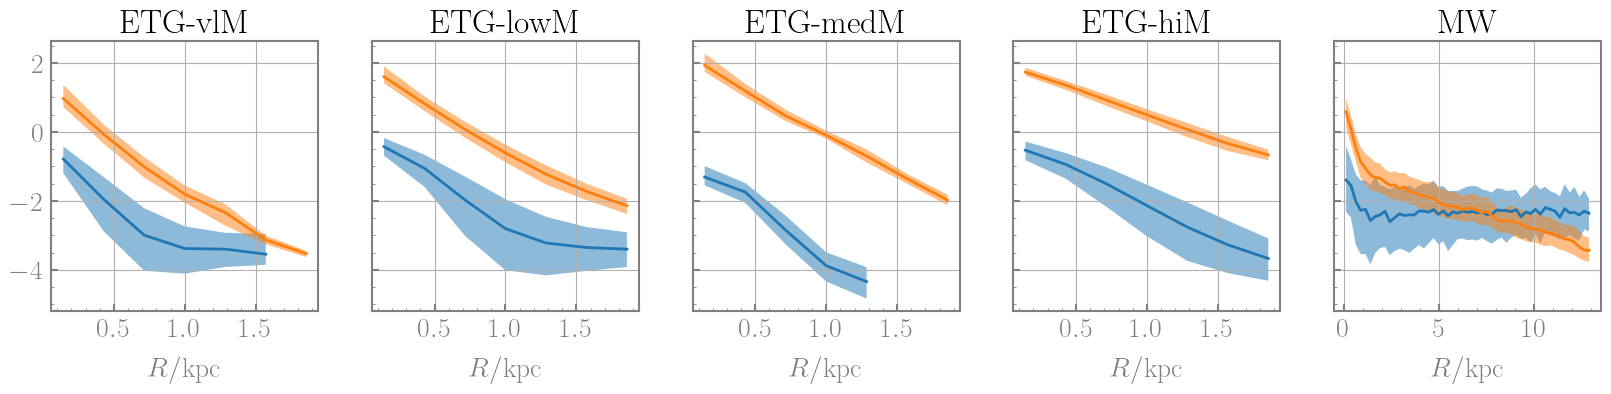

In [7]:
# plot the median weight as a function of R on a separate axis for each galaxy
fig, axs = plt.subplots(1, len(tags), figsize=(4*len(tags), 3.5), sharey=True)
for ax, tag, SigmaSFRs, SigmaSFRs_PRFM, Rs, Rs_PRFM, xymax in zip(axs, tags, SigmaSFRs_gal, SigmaSFRs_gal_PRFM, Rs_gal, Rs_gal_PRFM, xymaxs):
    bins = np.linspace(0., xymax, int(np.rint(xymax/0.25)))
    Rbins = 0.5*(bins[:-1] + bins[1:])
    cnd = SigmaSFRs > 0.
    SFRs_med, _, _ = binned_statistic(Rs[cnd], SigmaSFRs[cnd], bins=bins, statistic='median')
    SFRs_q1, _, _ = binned_statistic(Rs[cnd], SigmaSFRs[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    SFRs_q4, _, _ = binned_statistic(Rs[cnd], SigmaSFRs[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    SFRs_PRFM_med, _, _ = binned_statistic(Rs_PRFM, SigmaSFRs_PRFM, bins=bins, statistic='median')
    SFRs_PRFM_q1, _, _ = binned_statistic(Rs_PRFM, SigmaSFRs_PRFM, bins=bins, statistic=lambda x: np.percentile(x, 25))
    SFRs_PRFM_q4, _, _ = binned_statistic(Rs_PRFM, SigmaSFRs_PRFM, bins=bins, statistic=lambda x: np.percentile(x, 75))
    
    ax.plot(Rbins, np.log10(SFRs_med/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s), lw=2)
    ax.fill_between(Rbins,
                    np.log10(SFRs_q1/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s),
                    np.log10(SFRs_q4/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s), alpha=0.5)

    ax.plot(Rbins, np.log10(SFRs_PRFM_med/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s), lw=2)
    ax.fill_between(Rbins,
                    np.log10(SFRs_PRFM_q1/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s),
                    np.log10(SFRs_PRFM_q4/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s), alpha=0.5)

    ax.set_xlabel(r'$R/{\rm kpc}$')
    ax.set_title(tag)
    ax.tick_params(axis='both', direction='in', which='both')
    ax.minorticks_on()
    ax.grid(True)
plt.show()

# Springel Hernquist SFR

In [8]:
# separate by galaxy
SigmaSFRs_gal_SH03, Rs_gal_SH03 = [], []
for tag, xymax in zip(tags, xymaxs):
    mask = df['galaxy'] == tag
    rhogas = df.loc[mask, 'gas_voldens']
    SigmaGas = df.loc[mask, 'gas_surfdens']
    Rs = df.loc[mask, 'R/Router'] * xymax

    tau_dep0 = 2.1 * ah.Gyr_to_s
    rhothresh = 0.13 * ah.mp_cgs # g/cm^3
    tau_dep = tau_dep0 * (rhogas / rhothresh)**(-0.5)
    SigmaSFR = SigmaGas / tau_dep

    Rs_gal_SH03.append(Rs)
    SigmaSFRs_gal_SH03.append(SigmaSFR)

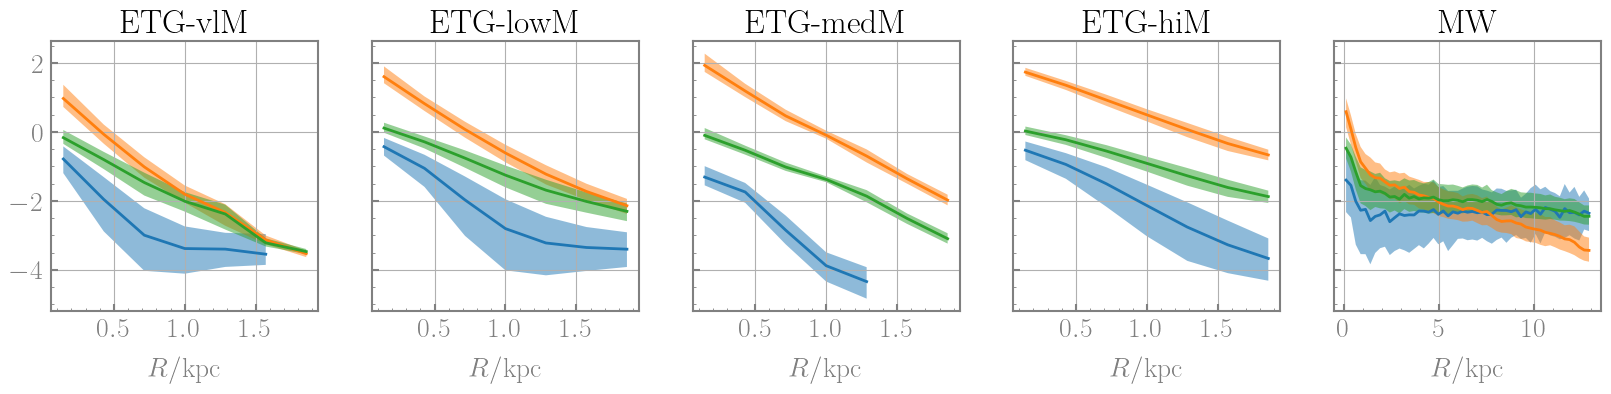

In [9]:
# plot the median weight as a function of R on a separate axis for each galaxy
fig, axs = plt.subplots(1, len(tags), figsize=(4*len(tags), 3.5), sharey=True)
for ax, tag, SigmaSFRs, SigmaSFRs_PRFM, SigmaSFRs_SH03, Rs, Rs_PRFM, Rs_SH03, xymax in zip(
    axs, tags, SigmaSFRs_gal, SigmaSFRs_gal_PRFM, SigmaSFRs_gal_SH03, Rs_gal, Rs_gal_PRFM, Rs_gal_SH03, xymaxs):
    bins = np.linspace(0., xymax, int(np.rint(xymax/0.25)))
    Rbins = 0.5*(bins[:-1] + bins[1:])
    cnd = SigmaSFRs > 0.
    SFRs_med, _, _ = binned_statistic(Rs[cnd], SigmaSFRs[cnd], bins=bins, statistic='median')
    SFRs_q1, _, _ = binned_statistic(Rs[cnd], SigmaSFRs[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    SFRs_q4, _, _ = binned_statistic(Rs[cnd], SigmaSFRs[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    SFRs_PRFM_med, _, _ = binned_statistic(Rs_PRFM, SigmaSFRs_PRFM, bins=bins, statistic='median')
    SFRs_PRFM_q1, _, _ = binned_statistic(Rs_PRFM, SigmaSFRs_PRFM, bins=bins, statistic=lambda x: np.percentile(x, 25))
    SFRs_PRFM_q4, _, _ = binned_statistic(Rs_PRFM, SigmaSFRs_PRFM, bins=bins, statistic=lambda x: np.percentile(x, 75))
    cnd = SigmaSFRs_SH03 > 0.
    SFRs_SH03_med, _, _ = binned_statistic(Rs_SH03[cnd], SigmaSFRs_SH03[cnd], bins=bins, statistic='median')
    SFRs_SH03_q1, _, _ = binned_statistic(Rs_SH03[cnd], SigmaSFRs_SH03[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    SFRs_SH03_q4, _, _ = binned_statistic(Rs_SH03[cnd], SigmaSFRs_SH03[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    
    ax.plot(Rbins, np.log10(SFRs_med/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s), lw=2)
    ax.fill_between(Rbins,
                    np.log10(SFRs_q1/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s),
                    np.log10(SFRs_q4/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s), alpha=0.5)

    ax.plot(Rbins, np.log10(SFRs_PRFM_med/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s), lw=2)
    ax.fill_between(Rbins,
                    np.log10(SFRs_PRFM_q1/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s),
                    np.log10(SFRs_PRFM_q4/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s), alpha=0.5)
    
    ax.plot(Rbins, np.log10(SFRs_SH03_med/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s), lw=2)
    ax.fill_between(Rbins,
                    np.log10(SFRs_SH03_q1/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s),
                    np.log10(SFRs_SH03_q4/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s), alpha=0.5)

    ax.set_xlabel(r'$R/{\rm kpc}$')
    ax.set_title(tag)
    ax.tick_params(axis='both', direction='in', which='both')
    ax.minorticks_on()
    ax.grid(True)
plt.show()

# ML fitting SFR

In [12]:
SigmaSFRs_MLP_gal, Rs_MLP_gal = [], []
for tag, xymax in zip(tags, xymaxs):
    df = pl.read_parquet('/n/holystore01/LABS/itc_lab/Users/sjeffreson/GalactISM/GalactISM_'+tag+'_pred-SFR.parquet').to_pandas()
    SigmaSFRs_MLP_gal.append(df['SFR_surfdens'])
    Rs_MLP_gal.append(df['R/Router'] * xymax)

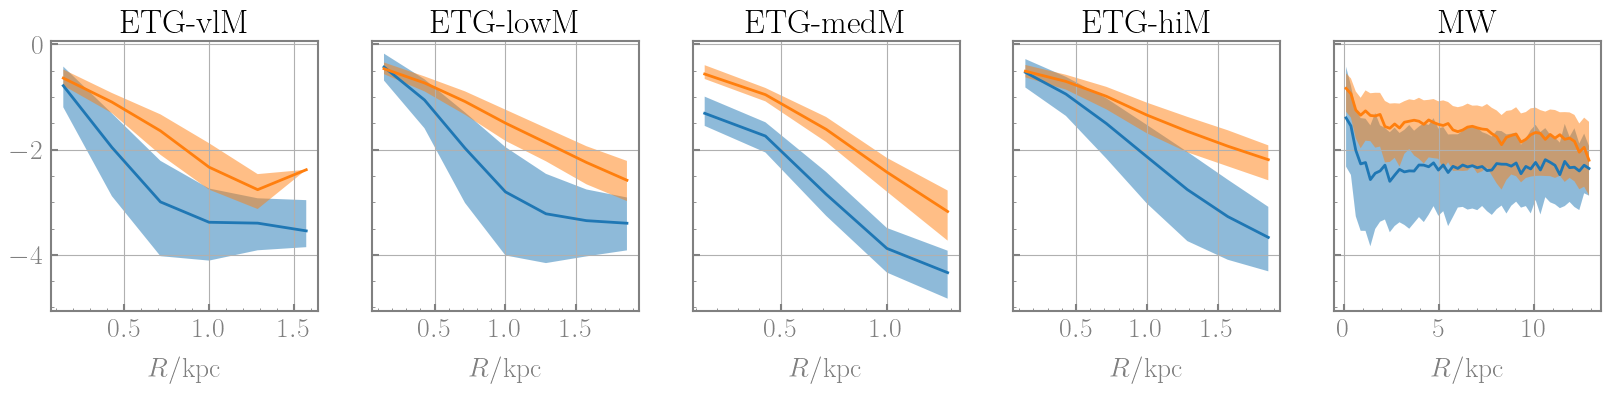

In [11]:
fig, axs = plt.subplots(1, len(tags), figsize=(4*len(tags), 3.5), sharey=True)
for ax, tag, SigmaSFRs, SigmaSFRs_MLP, Rs, Rs_MLP, xymax in zip(axs, tags, SigmaSFRs_gal, SigmaSFRs_MLP_gal, Rs_gal, Rs_MLP_gal, xymaxs):
    bins = np.linspace(0., xymax, int(np.rint(xymax/0.25)))
    Rbins = 0.5*(bins[:-1] + bins[1:])
    cnd = SigmaSFRs > 0.
    SigmaSFRs_med, _, _ = binned_statistic(Rs[cnd], SigmaSFRs[cnd], bins=bins, statistic='median')
    SigmaSFRs_q1, _, _ = binned_statistic(Rs[cnd], SigmaSFRs[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    SigmaSFRs_q4, _, _ = binned_statistic(Rs[cnd], SigmaSFRs[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))

    cnd = SigmaSFRs_MLP > 0.
    SigmaSFRs_MLP_med, _, _ = binned_statistic(Rs_MLP[cnd], SigmaSFRs_MLP[cnd], bins=bins, statistic='median')
    SigmaSFRs_MLP_q1, _, _ = binned_statistic(Rs_MLP[cnd], SigmaSFRs_MLP[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    SigmaSFRs_MLP_q4, _, _ = binned_statistic(Rs_MLP[cnd], SigmaSFRs_MLP[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))

    ax.plot(Rbins, np.log10(SigmaSFRs_med/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s), lw=2)
    ax.fill_between(Rbins,
                    np.log10(SigmaSFRs_q1/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s),
                    np.log10(SigmaSFRs_q4/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s), alpha=0.5)

    ax.plot(Rbins, np.log10(SigmaSFRs_MLP_med/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s), lw=2)
    ax.fill_between(Rbins,
                    np.log10(SigmaSFRs_MLP_q1/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s),
                    np.log10(SigmaSFRs_MLP_q4/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s), alpha=0.5)
    
    ax.set_xlabel(r'$R/{\rm kpc}$')
    ax.set_title(tag)
    ax.tick_params(axis='both', direction='in', which='both')
    ax.minorticks_on()
    ax.grid(True)